## 1. Tabular dataset -> Graph dataset

### 1.1 Homogeneous

- `Nodes` - Football players (by ID)
- `Edges` - If they play for the same team (see explanation below)
- `Node Features` - The football player's position, specialities, ball control, ...
- `Labels` - The football player's overall rating (node-level regression task)

In [1]:
import pandas as pd 

In [2]:
player_df = pd.read_csv('./Data/Tabular Dataset/tbl_player.csv')
skill_df = pd.read_csv('./Data/Tabular Dataset/tbl_player_skill.csv')
team_df = pd.read_csv('./Data/Tabular Dataset/tbl_team.csv')

In [3]:
player_df = player_df[['int_player_id', 'str_player_name', 'str_positions', 'int_overall_rating', 'int_team_id']]
skill_df = skill_df[['int_player_id', 'int_long_passing', 'int_ball_control', 'int_dribbling']]
team_df = team_df[['int_team_id', 'str_team_name', 'int_overall']]

In [4]:
player_df = player_df.merge(skill_df, on='int_player_id')
fifa_df = player_df.merge(team_df, on='int_team_id')

In [5]:
fifa_df = fifa_df.sort_values(by='int_overall_rating', ascending=False)
print('Players:', fifa_df.shape[0])
fifa_df.head() 

Players: 18767


,int_player_id,str_player_name,str_positions,int_overall_rating,int_team_id,int_long_passing,int_ball_control,int_dribbling,str_team_name,int_overall
0,1,Lionel Andrés Messi Cuccittini,"RW, ST, CF",93,5.0,91,96,96,FC Barcelona,84
33,2,Cristiano Ronaldo dos Santos Aveiro,"ST, LW",92,6.0,77,92,88,Juventus,83
57,3,Jan Oblak,GK,91,8.0,40,30,12,Atlético Madrid,83
121,5,Neymar da Silva Santos Júnior,"LW, CAM",91,7.0,81,95,95,Paris Saint-Germain,83
89,4,Kevin De Bruyne,"CAM, CM",91,2.0,93,92,88,Manchester City,85


In [6]:
max(fifa_df['int_player_id'].value_counts())

1

In [7]:
sorted_df = fifa_df.sort_values(by='int_player_id')
node_features = sorted_df[['str_positions', 'int_long_passing', 'int_ball_control', 'int_dribbling']]

pd.set_option('mode.chained_assignment', None)

positions = node_features['str_positions'].str.split(',', expand=True)
node_features['first_position'] = positions[0]

node_features = pd.concat([node_features, pd.get_dummies(node_features['first_position'])], axis=1, join='inner')
node_features.drop(['str_positions', 'first_position'], axis=1, inplace=True)
node_features.head()

,int_long_passing,int_ball_control,int_dribbling,CAM,CB,CDM,CF,CM,GK,LB,LM,LW,LWB,RB,RM,RW,RWB,ST
0,91,96,96,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
33,77,92,88,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
57,40,30,12,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
89,93,92,88,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
121,81,95,95,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


In [8]:
x = node_features.to_numpy() 
x.shape   

(18767, 18)

In [9]:
sorted_df = fifa_df.sort_values(by='int_player_id')
labels = sorted_df[['int_overall']]
labels.head() 

,int_overall
0,84
33,83
57,83
89,85
121,83


In [10]:
y = labels.to_numpy() 
y.shape 

(18767, 1)

In [11]:
fifa_df['int_player_id'] = fifa_df.reset_index().index

In [12]:
fifa_df['str_team_name'].value_counts()

Everton                   36
Valencia CF               34
FC Nantes                 34
Villarreal CF             34
Real Valladolid CF        34
                          ..
Wellington Phoenix        19
Central Coast Mariners    19
Melbourne Victory         19
Brisbane Roar             19
Adelaide United           19
Name: str_team_name, Length: 681, dtype: int64

In [13]:
import itertools 
import numpy as np 
from tqdm import tqdm

In [14]:
teams = fifa_df['str_team_name'].unique() 
all_edges = np.array([], dtype=np.int32).reshape((0, 2))

for team in tqdm(teams):
    team_df = fifa_df[fifa_df['str_team_name'] == team]
    players = team_df['int_player_id'].values 
    permutations = list(itertools.combinations(players, 2))
    edge_sources = [e[0] for e in permutations]
    edge_targets = [e[1] for e in permutations]
    team_edges = np.column_stack([edge_sources, edge_targets])
    all_edges = np.vstack([all_edges, team_edges])
    
edge_index = all_edges.transpose() 
edge_index

100%|███████████████████████████████████████████████████████████████████████████████| 681/681 [00:01<00:00, 524.92it/s]


array([[    0,     0,     0, ..., 18704, 18704, 18719],
       [    7,    32,    45, ..., 18719, 18751, 18751]], dtype=int64)

In [15]:
from torch_geometric.data import Data 

C:\Users\86183\anaconda3\lib\site-packages\torch_geometric\typing.py:31: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: [WinError 127] 找不到指定的程序。
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "


In [16]:
data = Data(x=x, edge_index=edge_index, y=y)

In [17]:
print(data)

Data(x=[18767, 18], edge_index=[2, 251934], y=[18767, 1])


### 1.2 Heterogeneous

- `Nodes` - Users and Animes (two node types with different features = heterogeneous)
- `Edges` - If a user has rated a movie / the rating (edge weight)
- `Node Features` - The movie attributes and for the users we have no explicit features so we have to figure something out later 
- `Labels` - The rating for a movie (link prediction regression task)

In [18]:
import pandas as pd 
import matplotlib.pyplot as plt 

In [19]:
anime = pd.read_csv('./Data/Tabular Dataset/anime.csv')
rating = pd.read_csv('./Data/Tabular Dataset/rating.csv')

In [20]:
anime.head()

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266


In [21]:
rating.head()

,user_id,anime_id,rating
0,1,20,-1
1,1,24,-1
2,1,79,-1
3,1,226,-1
4,1,241,-1


In [22]:
sorted_df = anime.sort_values(by='anime_id').set_index('anime_id')

sorted_df = sorted_df.reset_index(drop=False)
movie_id_mapping = sorted_df['anime_id']

node_features = sorted_df[['type', 'genre', 'episodes']]
pd.set_option('mode.chained_assignment', None)

genres = node_features['genre'].str.split(',', expand=True)
node_features['main_genre'] = genres[0] 

anime_node_features = pd.concat([node_features, pd.get_dummies(node_features['main_genre'])], axis=1, join='inner')
anime_node_features = pd.concat([anime_node_features, pd.get_dummies(anime_node_features['type'])], axis=1, join='inner')
anime_node_features.drop(['genre', 'main_genre'], axis=1, inplace=True)
anime_node_features.head(10)

,type,episodes,Action,Adventure,Cars,Comedy,Dementia,Demons,Drama,Ecchi,...,Supernatural,Thriller,Vampire,Yaoi,Movie,Music,ONA,OVA,Special,TV
0,TV,26,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,Movie,1,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,TV,26,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,TV,26,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,TV,52,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
5,TV,145,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
6,TV,24,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
7,TV,52,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
8,TV,24,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
9,TV,74,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1


In [23]:
x = anime_node_features.to_numpy() 
x.shape  

(12294, 48)

In [24]:
mean_rating = rating.groupby('user_id')['rating'].mean().rename('mean')
num_rating = rating.groupby('user_id')['rating'].count().rename('count')
user_node_features = pd.concat([mean_rating, num_rating], axis=1)

user_node_features = user_node_features.reset_index(drop=False)
user_id_mapping = user_node_features['user_id']

user_node_features = user_node_features[['mean', 'count']]
user_node_features.head()

,mean,count
0,-0.712418,153
1,2.666667,3
2,7.382979,94
3,-1.000000,52
4,4.263383,467


In [25]:
x = user_node_features.to_numpy()
x.shape

(73515, 2)

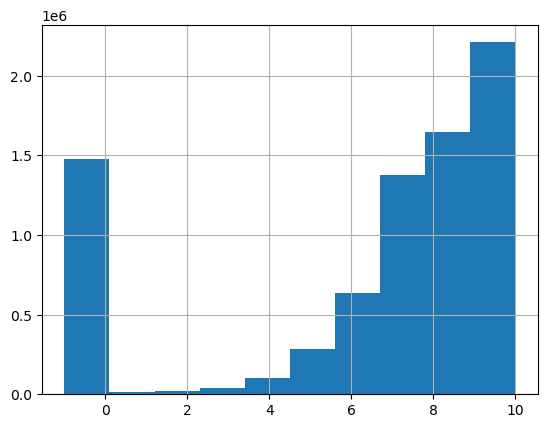

In [26]:
rating['rating'].hist() 
plt.show()

In [27]:
rating['anime_id'].unique()

array([   20,    24,    79, ..., 29481, 34412, 30738], dtype=int64)

In [28]:
anime['anime_id'].sort_values().unique()

array([    1,     5,     6, ..., 34522, 34525, 34527], dtype=int64)

In [29]:
print(set(rating['anime_id'].unique()) - set(anime['anime_id'].unique()))
rating = rating[~rating['anime_id'].isin([30913, 30924, 20261])]

{30913, 30924, 20261}


In [30]:
labels = rating['rating']
labels.tail()

7813732     7
7813733     9
7813734    10
7813735     9
7813736     9
Name: rating, dtype: int64

In [31]:
y = labels.to_numpy() 
y.shape 

(7813727,)

In [32]:
movie_map = movie_id_mapping.reset_index().set_index('anime_id').to_dict()
rating['anime_id'] = rating['anime_id'].map(movie_map['index']).astype(int)

user_map = user_id_mapping.reset_index().set_index('user_id').to_dict() 
rating['user_id'] = rating['user_id'].map(user_map['index']).astype(int)

rating.head()

,user_id,anime_id,rating
0,0,10,-1
1,0,14,-1
2,0,58,-1
3,0,202,-1
4,0,217,-1


In [33]:
edge_index = rating[['user_id', 'anime_id']].values.transpose() 
edge_index

array([[    0,     0,     0, ..., 73513, 73514, 73514],
       [   10,    14,    58, ...,  8624,   718,  5226]])

In [34]:
from torch_geometric.data import HeteroData

In [35]:
data = HeteroData()
data['user'].x = user_node_features 
data['movie'].x = anime_node_features
data['user', 'rating', 'movie'].edge_index = edge_index
data['user', 'movie'].y = y 

In [36]:
data 

HeteroData(
  user={ x=            mean  count
0      -0.712418    153
1       2.666667      3
2       7.382979     94
3      -1.000000     52
4       4.263383    467
...          ...    ...
73510   7.846154     13
73511   7.515152     33
73512  10.000000      1
73513   7.719388    196
73514   9.000000      2

[73515 rows x 2 columns] },
  movie={ x=          type episodes  Action  Adventure  Cars  Comedy  Dementia  Demons  \
0           TV       26       1          0     0       0         0       0   
1        Movie        1       1          0     0       0         0       0   
2           TV       26       1          0     0       0         0       0   
3           TV       26       1          0     0       0         0       0   
4           TV       52       0          1     0       0         0       0   
...        ...      ...     ...        ...   ...     ...       ...     ...   
12289      ONA       18       1          0     0       0         0       0   
12290  Special        9 

## 2. Tabular dataset -> Temporal Graph dataset

- `Nodes` - The locations between which the bikers can travel
- `Node Features` - Attributes about a location, for example average number of bikers that start / end here, average traffic, ... (whatever is available)
- `Edges / Edge weights` - Proximity between two addresses (available) / Connection according to road network (not available here)
- `Edge features` - To incorporate the individual bike information, we can simply model this as edge features i.e. number of bikes, average trip duration, ...
- `Labels` - The trip duration, which makes it a link-prediction task
- `Timesteps` - 60 min steps (we have 1 month of data = ~ 700 graphs)

In [37]:
trips = pd.read_csv('./Data/Tabular Dataset/201306-citibike-tripdata.csv')
trips.head()

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender
0,695,2013-06-01 00:00:01,2013-06-01 00:11:36,444,Broadway & W 24 St,40.742354,-73.989151,434.0,9 Ave & W 18 St,40.743174,-74.003664,19678,Subscriber,1983.0,1
1,693,2013-06-01 00:00:08,2013-06-01 00:11:41,444,Broadway & W 24 St,40.742354,-73.989151,434.0,9 Ave & W 18 St,40.743174,-74.003664,16649,Subscriber,1984.0,1
2,2059,2013-06-01 00:00:44,2013-06-01 00:35:03,406,Hicks St & Montague St,40.695128,-73.995951,406.0,Hicks St & Montague St,40.695128,-73.995951,19599,Customer,NaN,0
3,123,2013-06-01 00:01:04,2013-06-01 00:03:07,475,E 15 St & Irving Pl,40.735243,-73.987586,262.0,Washington Park,40.691782,-73.973730,16352,Subscriber,1960.0,1
4,1521,2013-06-01 00:01:22,2013-06-01 00:26:43,2008,Little West St & 1 Pl,40.705693,-74.016777,310.0,State St & Smith St,40.689269,-73.989129,15567,Subscriber,1983.0,1


In [38]:
cols_to_drop = ['start station name', 'end station name']
trips.dropna(inplace=True)
trips.drop(cols_to_drop, axis=1, inplace=True)
trips.head()  

,tripduration,starttime,stoptime,start station id,start station latitude,start station longitude,end station id,end station latitude,end station longitude,bikeid,usertype,birth year,gender
0,695,2013-06-01 00:00:01,2013-06-01 00:11:36,444,40.742354,-73.989151,434.0,40.743174,-74.003664,19678,Subscriber,1983.0,1
1,693,2013-06-01 00:00:08,2013-06-01 00:11:41,444,40.742354,-73.989151,434.0,40.743174,-74.003664,16649,Subscriber,1984.0,1
3,123,2013-06-01 00:01:04,2013-06-01 00:03:07,475,40.735243,-73.987586,262.0,40.691782,-73.973730,16352,Subscriber,1960.0,1
4,1521,2013-06-01 00:01:22,2013-06-01 00:26:43,2008,40.705693,-74.016777,310.0,40.689269,-73.989129,15567,Subscriber,1983.0,1
6,2057,2013-06-01 00:02:33,2013-06-01 00:36:50,285,40.734546,-73.990741,532.0,40.710451,-73.960876,15693,Subscriber,1991.0,1


In [39]:
locations = trips['start station id'].unique()
new_ids = list(range(len(trips['start station id'].unique())))
mapping = dict(zip(locations, new_ids))

trips['start station id'] = trips['start station id'].map(mapping)
trips['end station id'] = trips['end station id'].map(mapping)
trips.head()

,tripduration,starttime,stoptime,start station id,start station latitude,start station longitude,end station id,end station latitude,end station longitude,bikeid,usertype,birth year,gender
0,695,2013-06-01 00:00:01,2013-06-01 00:11:36,0,40.742354,-73.989151,299,40.743174,-74.003664,19678,Subscriber,1983.0,1
1,693,2013-06-01 00:00:08,2013-06-01 00:11:41,0,40.742354,-73.989151,299,40.743174,-74.003664,16649,Subscriber,1984.0,1
3,123,2013-06-01 00:01:04,2013-06-01 00:03:07,1,40.735243,-73.987586,187,40.691782,-73.973730,16352,Subscriber,1960.0,1
4,1521,2013-06-01 00:01:22,2013-06-01 00:26:43,2,40.705693,-74.016777,257,40.689269,-73.989129,15567,Subscriber,1983.0,1
6,2057,2013-06-01 00:02:33,2013-06-01 00:36:50,3,40.734546,-73.990741,280,40.710451,-73.960876,15693,Subscriber,1991.0,1


In [40]:
trips = trips.sort_values(by='starttime')
trips.head() 

,tripduration,starttime,stoptime,start station id,start station latitude,start station longitude,end station id,end station latitude,end station longitude,bikeid,usertype,birth year,gender
0,695,2013-06-01 00:00:01,2013-06-01 00:11:36,0,40.742354,-73.989151,299,40.743174,-74.003664,19678,Subscriber,1983.0,1
1,693,2013-06-01 00:00:08,2013-06-01 00:11:41,0,40.742354,-73.989151,299,40.743174,-74.003664,16649,Subscriber,1984.0,1
3,123,2013-06-01 00:01:04,2013-06-01 00:03:07,1,40.735243,-73.987586,187,40.691782,-73.973730,16352,Subscriber,1960.0,1
4,1521,2013-06-01 00:01:22,2013-06-01 00:26:43,2,40.705693,-74.016777,257,40.689269,-73.989129,15567,Subscriber,1983.0,1
6,2057,2013-06-01 00:02:33,2013-06-01 00:36:50,3,40.734546,-73.990741,280,40.710451,-73.960876,15693,Subscriber,1991.0,1


In [41]:
from datetime import datetime, timedelta 
import seaborn as sns 

sns.set(rc={'figure.figsize': (20, 6)})

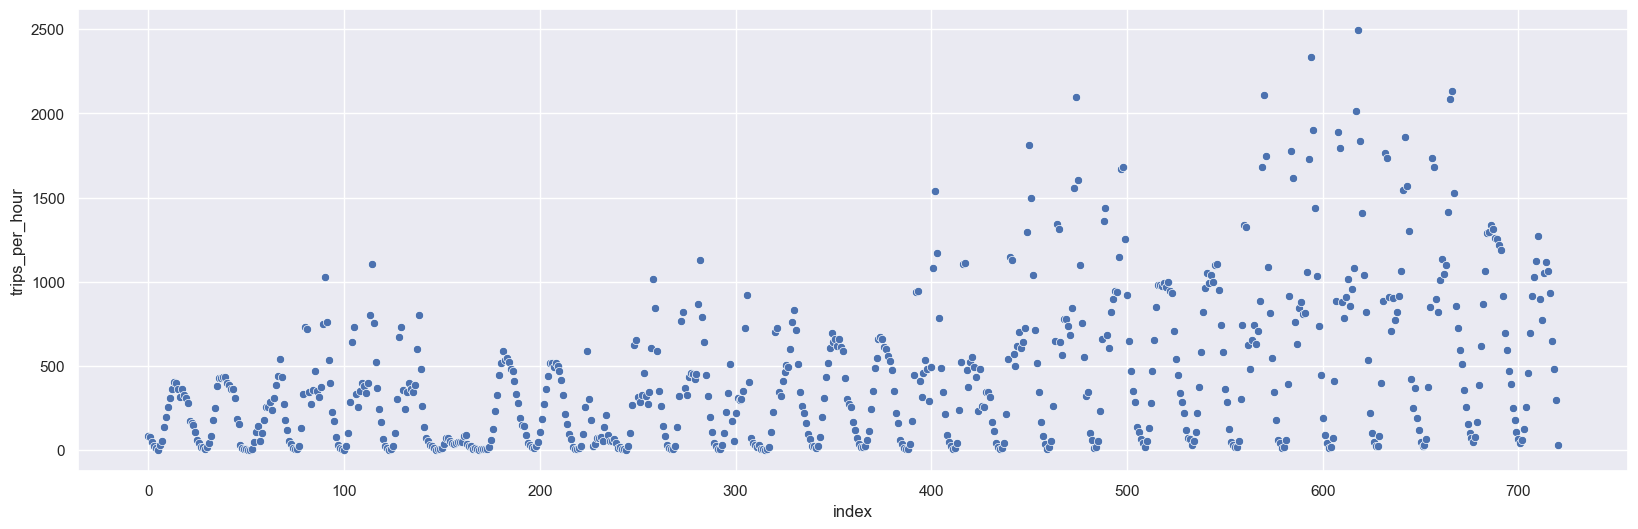

In [42]:
trips['starttime'] = pd.to_datetime(trips['starttime'], format='%Y-%m-%d %H:%M:%S')
trips['stoptime'] = pd.to_datetime(trips['stoptime'], format='%Y-%m-%d %H:%M:%S')

start_date = datetime.strptime('2013-06-01 00:00:01', '%Y-%m-%d %H:%M:%S')
end_date = datetime.strptime('2013-07-01 00:10:34', '%Y-%m-%d %H:%M:%S')
interval = timedelta(minutes=60)

bucket_elements = []
while start_date <= end_date:
    bucket_elements.append(trips[((start_date + interval) >= trips['stoptime']) & (start_date <= trips['stoptime'])].shape[0])
    start_date += interval 
    
sns.scatterplot(x='index', y='trips_per_hour', data=pd.DataFrame(bucket_elements, columns=['trips_per_hour']).reset_index())
plt.show()

In [43]:
outgoing_trips = trips.groupby('start station id').count()['bikeid'].values 
incoming_trips = trips.groupby('end station id').count()['bikeid'].values 

outgoing_trips = (outgoing_trips - np.min(outgoing_trips)) / (np.max(outgoing_trips) - np.min(outgoing_trips))
incoming_trips = (incoming_trips - np.min(incoming_trips)) / (np.max(incoming_trips) - np.min(incoming_trips))

node_features = np.stack([outgoing_trips, incoming_trips]).transpose() 
print('Full shape:', node_features.shape)
node_features[:10]

Full shape: (337, 2)


array([[0.76524844, 0.79829787],
       [0.39452544, 0.36964539],
       [0.16691461, 0.18751773],
       [0.92740256, 0.86297872],
       [0.6155906 , 0.62014184],
       [0.27700089, 0.28028369],
       [0.62600417, 0.62099291],
       [0.27848855, 0.22978723],
       [0.12734305, 0.11177305],
       [0.2692651 , 0.24879433]])

In [44]:
from sklearn.utils.extmath import cartesian 
from geopy.distance import geodesic

In [45]:
subset = ['start station longitude', 'start station latitude', 'start station id']
all_starts = trips.drop_duplicates(subset='start station id', keep='first')[subset]

subset = ['end station longitude', 'end station latitude', 'end station id']
all_ends = trips.drop_duplicates(subset='end station id', keep='first')[subset]

distance_matrix = all_ends.merge(all_starts, how='cross')
distance_matrix['distance'] = distance_matrix.apply(lambda x: geodesic((x['start station latitude'], x['start station longitude']), 
                                                                       (x['end station latitude'], x['end station longitude'])).meters, axis=1)
distance_matrix.head()

,end station longitude,end station latitude,end station id,start station longitude,start station latitude,start station id,distance
0,-74.003664,40.743174,299,-73.989151,40.742354,0,1229.224446
1,-74.003664,40.743174,299,-73.987586,40.735243,1,1618.732623
2,-74.003664,40.743174,299,-74.016777,40.705693,2,4307.215223
3,-74.003664,40.743174,299,-73.990741,40.734546,3,1452.477060
4,-74.003664,40.743174,299,-73.983799,40.726218,118,2522.253218


In [46]:
distance_matrix['edge'] = distance_matrix['distance'] < 500 
distance_matrix.head() 

,end station longitude,end station latitude,end station id,start station longitude,start station latitude,start station id,distance,edge
0,-74.003664,40.743174,299,-73.989151,40.742354,0,1229.224446,False
1,-74.003664,40.743174,299,-73.987586,40.735243,1,1618.732623,False
2,-74.003664,40.743174,299,-74.016777,40.705693,2,4307.215223,False
3,-74.003664,40.743174,299,-73.990741,40.734546,3,1452.477060,False
4,-74.003664,40.743174,299,-73.983799,40.726218,118,2522.253218,False


In [47]:
edge_index = distance_matrix[distance_matrix['edge'] == True][['start station id', 'end station id']].values
edge_index = edge_index.transpose() 
edge_index

array([[  4,   6,  15, ..., 315, 317, 327],
       [299, 299, 299, ..., 272, 272, 272]], dtype=int64)

In [48]:
distance_feature = distance_matrix[distance_matrix['edge'] == True]['distance'].values 
edge_type_feature = np.zeros_like(distance_feature)
trip_duration_feature = np.zeros_like(distance_feature)
static_edge_features = np.stack([distance_feature, edge_type_feature, trip_duration_feature]).transpose() 
static_edge_features

array([[294.92884499,   0.        ,   0.        ],
       [327.27388739,   0.        ,   0.        ],
       [419.30404213,   0.        ,   0.        ],
       ...,
       [379.44132957,   0.        ,   0.        ],
       [349.85678078,   0.        ,   0.        ],
       [332.80260533,   0.        ,   0.        ]])

In [49]:
def extract_dynamic_edges(s):
    trip_indices = s[['start station id', 'end station id']].values 
    trip_durations = s['tripduration']
    
    distance_feature = pd.DataFrame(trip_indices, columns=['start station id', 'end station id']).merge(distance_matrix, on=['start station id', 'end station id'], how='left')['distance'].values
    edge_type_feature = np.ones_like(distance_feature)
    trip_duration_feature = trip_durations 
    edge_features = np.stack([distance_feature, edge_type_feature, trip_duration_feature]).transpose() 
    return edge_features, trip_indices.transpose()


start_date = datetime.strptime('2013-06-01 00:00:01', '%Y-%m-%d %H:%M:%S')
end_date = datetime.strptime('2013-07-01 00:10:34', '%Y-%m-%d %H:%M:%S')
interval = timedelta(minutes=60)

xs = []
edge_indices = []
ys = [] 
y_indices = []
edge_features = [] 

while start_date <= end_date:
    current_snapshot = trips[((start_date + interval) >= trips['stoptime']) & (start_date <= trips['stoptime'])]
    subsequent_snapshot = trips[((start_date + 2 * interval) >= trips['stoptime']) & (start_date + interval <= trips['stoptime'])]
    
    current_snapshot = current_snapshot.groupby(['start station id', 'end station id']).mean(numeric_only=True).reset_index() 
    subsequent_snapshot = subsequent_snapshot.groupby(['start station id', 'end station id']).mean(numeric_only=True).reset_index()
    
    edge_feats, additional_edge_index = extract_dynamic_edges(current_snapshot)
    extended_edge_index = np.concatenate([edge_index, additional_edge_index], axis=1)
    extended_edge_feats = np.concatenate([edge_feats, static_edge_features], axis=0)
    
    y = subsequent_snapshot['tripduration'].values 
    y_index = subsequent_snapshot[['start station id', 'end station id']].values 
    
    xs.append(node_features)
    edge_indices.append(extended_edge_index)
    edge_features.append(extended_edge_feats)
    ys.append(y)
    y_indices.append(y_index.transpose())
    
    start_date += interval

In [50]:
i = 2
print(f'''Example of graph snapshot {i}: \n
          Node feature shape: {xs[i].shape} \n
          Edge index shape: {edge_indices[i].shape} \n
          Edge feature shape: {edge_features[i].shape} \n 
          Labels shape: {ys[i].shape} \n
          Labels mask shape: {y_indices[i].shape}
      ''')

Example of graph snapshot 2: 

          Node feature shape: (337, 2) 

          Edge index shape: (2, 2773) 

          Edge feature shape: (2773, 3) 
 
          Labels shape: (25,) 

          Labels mask shape: (2, 25)
      
